In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LSTM, Input,SpatialDropout1D, GlobalMaxPool1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [4]:
# 5. Membaca file CSV ke dalam DataFrame
import pandas as pd
df = pd.read_csv('dataset_50k.csv')
df.head()

Unnamed: 0  Label                                         detokenize
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...
1           1      0   buang pikir negatif laku gelisah milik putus asa
2           2      1  jujur aku takut mati aku orang aku sulit paham...
3           3      0              saya mes pasang sepatu jam saya harap
4           4      1  capek hati banget aku allah aku kayak mata ora...

In [5]:
df = df.dropna()
df

Unnamed: 0  Label                                         detokenize
0               0      1  aku luka diri aku jalan hidup sulit orang tua ...
1               1      0   buang pikir negatif laku gelisah milik putus asa
2               2      1  jujur aku takut mati aku orang aku sulit paham...
3               3      0              saya mes pasang sepatu jam saya harap
4               4      1  capek hati banget aku allah aku kayak mata ora...
...           ...    ...                                                ...
50518       50518      0  curi rampok liar begal rakyat senantiasa resah...
50519       50519      0                      saya bicara saya buat tertawa
50520       50520      1  sakit sakit guna sakit bahagia sakit bohong or...
50521       50521      1                              lantai lantai gelisah
50522       50522      1  aku tulis catat kemarin kata tunang aku laku b...

[50523 rows x 3 columns]

In [6]:
df['label'] = df['Label'].apply(lambda x: 0 if x == 0 else 1)
df.head()

Unnamed: 0  Label                                         detokenize  label
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...      1
1           1      0   buang pikir negatif laku gelisah milik putus asa      0
2           2      1  jujur aku takut mati aku orang aku sulit paham...      1
3           3      0              saya mes pasang sepatu jam saya harap      0
4           4      1  capek hati banget aku allah aku kayak mata ora...      1

<BarContainer object of 2 artists>

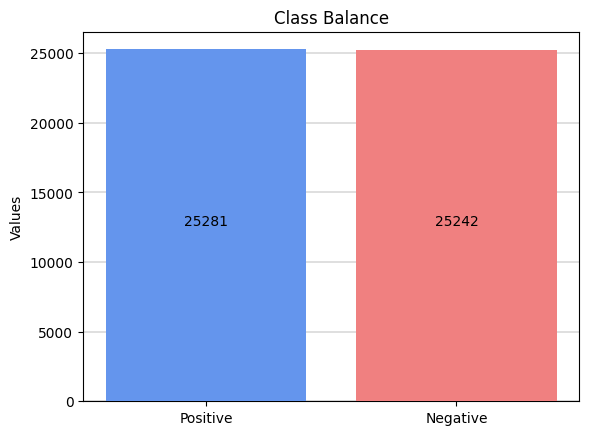

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',zorder=4)

# Count the values in the 'Label' column
count = df['Label'].value_counts()
x = ["Positive", "Negative"]  # Custom labels for class balance plot
y = [count[1], count[0]]
addlabels(x,y)
plt.ylabel("Values")
plt.title('Class Balance')
plt.grid(color='dimgray', linewidth=0.3, axis='y',zorder=0)
plt.bar(x,y, color= ['cornflowerblue', 'lightcoral'], zorder=3)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vektorisasi teks menggunakan TF-IDF unigram(1,1)
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,2), max_df=0.7, max_features=10000)

# Menggunakan fit_transform untuk mengubah dokumen menjadi fitur
vector = vectorizer.fit_transform(df['detokenize']).toarray()
tf_idf_len = len(vectorizer.vocabulary_)

In [9]:
#Split data 70% data train and 30% data test
x_unibi = pd.DataFrame(vector)
label = df["Label"]
x_train, x_test, y_train, y_test =  model_selection.train_test_split(x_unibi,label, test_size = 0.2)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(40418, 10000) (40418,)
(10105, 10000) (10105,)


In [10]:
y_train

7612     1
5686     1
22683    0
40764    1
3937     0
        ..
30324    0
26167    0
43950    0
35729    0
48104    1
Name: Label, Length: 40418, dtype: int64

In [11]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)

In [12]:
x_train

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [13]:
x_train.shape

(40418, 10000, 1)

In [14]:
import matplotlib.pyplot as plt

def make_plot(history, train, validation, title):
    graph = plt.plot(history.history[train], lw=2.0)
    graph = plt.plot(history.history[validation], lw=2.0)
    graph = plt.title(title)
    graph = plt.legend(['training', 'validasi'])
    graph = plt.show()

    return graph

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Membuat model cnn-lstm
def hybrid_cnn_lstm(x_train, y_train, x_test, y_test):


    model = Sequential()
    model.add(Input((x_train.shape[1], 1)))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=128,kernel_size=5,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(LSTM(128,return_sequences = True))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)] )

    #Membuat plot garis akurasi
    make_plot(history, "accuracy", "val_accuracy", "Perubahan Akurasi tiap epoch")

    #predict
    predictions = model.predict(x_test)
    print()
    print("Classification Report :")
    print(classification_report(y_test, predictions.round(), digits=6))


    acc_score = accuracy_score(y_test, predictions.round())
    prec_score = precision_score(y_test, predictions.round())
    rec_score = recall_score(y_test, predictions.round())
    f1score = f1_score(y_test, predictions.round())

    return [acc_score,prec_score,rec_score,f1score ]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d (SpatialDropout1D) │ (None, 10000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 9996, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 4998, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 639744)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │      20,471,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,604,225 (78.60 MB)

 Trainable params: 20,604,225 (78.60 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 293s 226ms/step - accuracy: 0.6937 - loss: 0.5261 - val_accuracy: 0.8177 - val_loss: 0.3757
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 299s 212ms/step - accuracy: 0.7762 - loss: 0.4021 - val_accuracy: 0.8194 - val_loss: 0.3669
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 339s 225ms/step - accuracy: 0.7988 - loss: 0.3615 - val_accuracy: 0.8214 - val_loss: 0.3656
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 304s 211ms/step - accuracy: 0.8149 - loss: 0.3306 - val_accuracy: 0.8230 - val_loss: 0.3647
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 340s 225ms/step - accuracy: 0.8267 - loss: 0.3007 - val_accuracy: 0.8197 - val_loss: 0.3849
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 322s 225ms/step - accuracy: 0.8343 - loss: 0.2830 - val_accuracy: 0.8230 - val_loss: 0.4051
Epoch 7/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 304s 211ms/step - accuracy: 0.8479 - loss: 0.2539 - val_accuracy: 0.8227 - val_loss: 0.4366


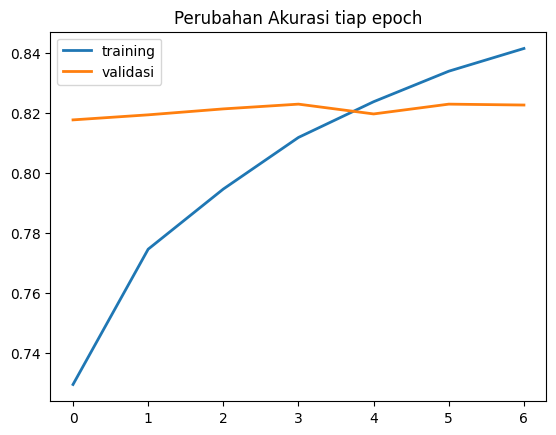

316/316 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.822668  0.818726  0.820692      5009
           1   0.822656  0.826531  0.824589      5096

    accuracy                       0.822662     10105
   macro avg   0.822662  0.822628  0.822641     10105
weighted avg   0.822662  0.822662  0.822657     10105



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_1                  │ (None, 10000, 1)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 9996, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 4998, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 639744)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │      20,471,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,604,225 (78.60 MB)

 Trainable params: 20,604,225 (78.60 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 271s 213ms/step - accuracy: 0.6738 - loss: 0.5519 - val_accuracy: 0.8131 - val_loss: 0.3778
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 323s 214ms/step - accuracy: 0.7718 - loss: 0.4085 - val_accuracy: 0.8183 - val_loss: 0.3630
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 338s 226ms/step - accuracy: 0.7895 - loss: 0.3712 - val_accuracy: 0.8111 - val_loss: 0.3690
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 321s 226ms/step - accuracy: 0.7988 - loss: 0.3546 - val_accuracy: 0.8252 - val_loss: 0.3596
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 305s 213ms/step - accuracy: 0.8139 - loss: 0.3268 - val_accuracy: 0.8209 - val_loss: 0.3849
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 286s 226ms/step - accuracy: 0.8228 - loss: 0.3074 - val_accuracy: 0.8148 - val_loss: 0.3815
Epoch 7/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 305s 213ms/step - accuracy: 0.8346 - loss: 0.2876 - val_accuracy: 0.8162 - val_loss: 0.4094


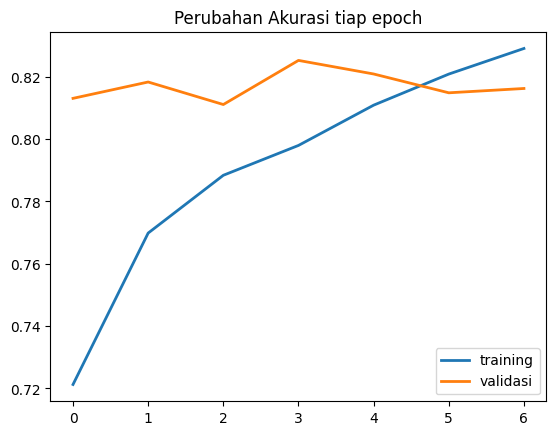

316/316 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.796575  0.845079  0.820110      5009
           1   0.838030  0.787873  0.812178      5096

    accuracy                       0.816230     10105
   macro avg   0.817302  0.816476  0.816144     10105
weighted avg   0.817481  0.816230  0.816110     10105



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_2                  │ (None, 10000, 1)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 9996, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 4998, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 639744)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │      20,471,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,604,225 (78.60 MB)

 Trainable params: 20,604,225 (78.60 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 272s 214ms/step - accuracy: 0.6872 - loss: 0.5330 - val_accuracy: 0.8069 - val_loss: 0.3835
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 321s 213ms/step - accuracy: 0.7688 - loss: 0.4099 - val_accuracy: 0.8177 - val_loss: 0.3634
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 322s 213ms/step - accuracy: 0.7919 - loss: 0.3650 - val_accuracy: 0.8225 - val_loss: 0.3589
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 339s 226ms/step - accuracy: 0.8099 - loss: 0.3336 - val_accuracy: 0.8204 - val_loss: 0.3611
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 322s 226ms/step - accuracy: 0.8240 - loss: 0.3071 - val_accuracy: 0.8233 - val_loss: 0.4093
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 268s 212ms/step - accuracy: 0.8316 - loss: 0.2903 - val_accuracy: 0.8198 - val_loss: 0.4257


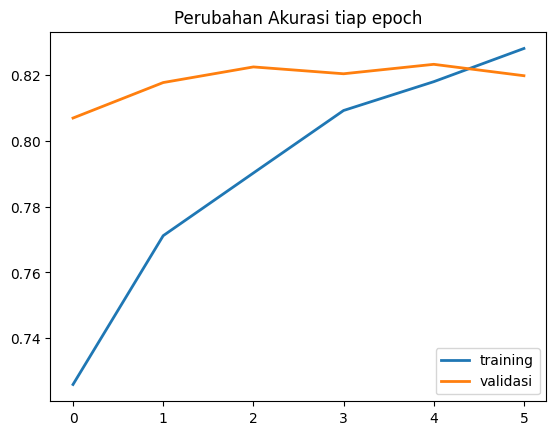

316/316 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.828254  0.802955  0.815408      5009
           1   0.811964  0.836342  0.823973      5096

    accuracy                       0.819792     10105
   macro avg   0.820109  0.819648  0.819690     10105
weighted avg   0.820039  0.819792  0.819727     10105



In [16]:
result = []
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))

In [18]:
average = np.mean(result, axis=0, dtype=float)
print('Average Accuracy  :', average[0])
print('Average Precision :', average[1])
print('Average Recall    :', average[2])
print('Average F1-Score  :', average[3])

Average Accuracy  : 0.8195612732970478
Average Precision : 0.8242166908534373
Average Recall    : 0.8169152276295133
Average F1-Score  : 0.82024647364367
